# Log File Outlier Detection

**Company Use Case:**

Due to the potential presence of sensitive patient data, log files cannot be shared or processed on the cloud directly. Homomorphic encryption comes into play by encrypting the log files and enabling predictive filtering of sensitive lines within them. This approach ensures data privacy while allowing for the extraction of valuable insights, particularly beneficial for enhancing predictive maintenance efforts.

**Approach:**

Since it's unknown which sensitive information could be contained in the log files the goal is to implement an anomaly detection algorithm which is trained on "normal samples" <span style="color:yellow">(_notice_ & _warn_ logs)</span>

The following Notebook will show two approaches to do this with ConcreteML.

**Dataset Information:**

_Dataset  1:_

<span style="color:yellow">description</span>

_Dataset 2:_

<span style="color:yellow">took from _loghub_</span>

Hadoop is a big data processing framework that allows for the distributed processing of large data sets across clusters of computers using simple programming models.The logs are generated from a Hadoop cluster with 46 cores across five machines simulating both normal and abnormal cases with injected specific failures for two applications (WordCount & PageRank)

**Dataset Source:**

https://github.com/logpai/loghub/tree/master

Dataset 1:

https://github.com/logpai/loghub/blob/master/Android/Android_2k.log_structured.csv

Dataset 2:

https://github.com/logpai/loghub/blob/master/Hadoop/Hadoop_2k.log_structured.csv

# Imports

In [1]:
# Basic Imports
import os
import shutil
import tempfile
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Scikit-Learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import *
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPRegressor

# XGBoost
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier

# Concrete ML
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier
from concrete.ml.sklearn import XGBRegressor as ConcreteXGBRegressor
from concrete.ml.sklearn import NeuralNetRegressor as ConcreteMLPRegressor

# Torch
import torch

# Transformers
from transformers import BertTokenizer, BertModel

In [2]:
# set random seed
np.random.seed(1)
torch.manual_seed(1)

# General Functions

In [3]:
#######################################################################################################
# Load Data
#######################################################################################################

def load_csv():

  '''
  Load csv files from github repo
  '''

  # github repo
  data_repo = 'https://github.com/logpai/loghub.git'
  # create temporary folder
  tmp_dir = tempfile.mkdtemp()
  # clone github repo to temporary folder
  !git clone $data_repo $tmp_dir
  # store dataframes in a dictionary
  data = {}
  # loop through all folders in the temporary folder and get all csv files ending with structured.csv
  for root, dirs, files in os.walk(tmp_dir):
    for file in files:
        if file.endswith('structured.csv'):
            log_name = file.split('_')[0].lower()
            data[log_name] = pd.read_csv(os.path.join(root, file))
  # delete temporary folder
  shutil.rmtree(tmp_dir)
  # return dataframes
  return data

################################################################################
# Plot Classification Metrics
################################################################################

def plot_classification_metrics(
    y_true: np.array,
    y_pred: np.array,
    plot_title: str = None
    ):

    '''
    Plots Classification Metrics

    Input:
      y_true = ground truth labels
      y_pred = prediction labels
      plot_title = title for results plot (optional)
    '''

    fig, ax = plt.subplots(2, 1, figsize=(5, 5))
    ax = ax.flatten()

    accuracy = round(accuracy_score(y_true, y_pred),2)
    precision = round(precision_score(y_true, y_pred),2)
    recall = round(recall_score(y_true, y_pred),2)
    f1 = round(f1_score(y_true, y_pred),2)
    roc_auc = round(roc_auc_score(y_true, y_pred), 2)

    # barchart of metrics for each classifier
    ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1', 'RocAuc'], [accuracy, precision, recall, f1, roc_auc])
    ax[0].set_title('Classifier Metrics')
    ax[0].set_ylim(0,1)
    ax[0].bar_label(ax[0].containers[0], label_type='center')

    # confusion matrix for each classifier
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1], cmap='Blues', colorbar=False)
    ax[1].set_title('Classifier Confusion Matrix')

    plt.suptitle(plot_title)
    plt.tight_layout()

    plt.show()

# Load Data

<span style="color:yellow">consider not only using text</span>

In [4]:
data = load_csv()

Cloning into '/tmp/tmplj_mta5k'...
remote: Enumerating objects: 563, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 563 (delta 58), reused 58 (delta 49), pack-reused 476
Receiving objects: 100% (563/563), 7.32 MiB | 1.57 MiB/s, done.
Resolving deltas: 100% (259/259), done.


In [5]:
# filter datasets to only include the ones which have a Level column (containing: Warning, Info, Error, ...)
data = {k:v for k,v in data.items() if 'Level' in v.columns}
# check for unique logs based on EventTemplate
unique_logs = pd.Series({key: len(data[key]['EventTemplate'].unique()) for key in data.keys()})
unique_logs = unique_logs.sort_values(ascending=False)
print('Unique Logs per Dataset')
unique_logs

Unique Logs per Dataset


android      166
bgl          120
linux        118
hadoop       114
zookeeper     50
windows       50
openstack     43
spark         36
hdfs          14
apache         6
dtype: int64

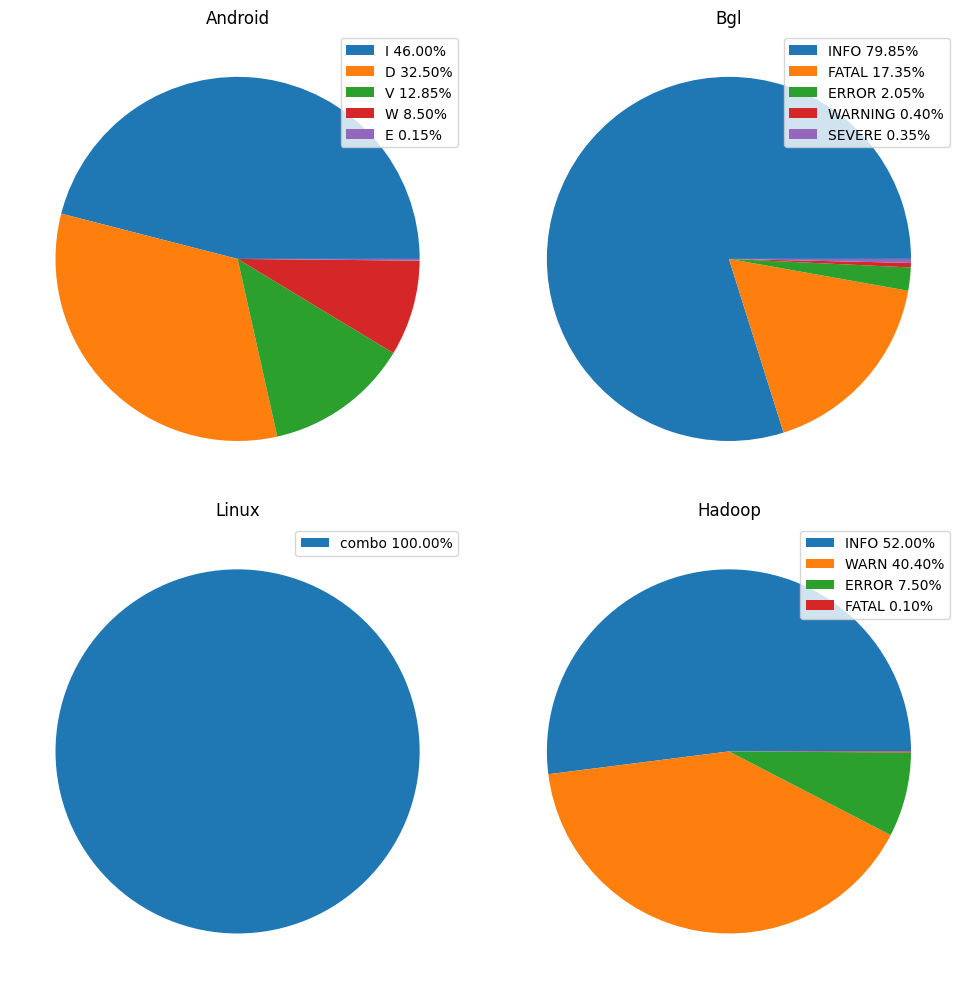

In [6]:
# piechart of log levels of ['android', 'bgl', 'linux', 'hadoop'] datasets
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, log in enumerate(['android', 'bgl', 'linux', 'hadoop']):
    counts = data[log]['Level'].value_counts()
    percentages = 100 * counts / counts.sum()
    labels = [f'{level} {percentage:.2f}%' for level, percentage in zip(counts.index, percentages)]
    
    axs[i].pie(counts, labels=None)
    axs[i].set_title(log.title())
    axs[i].legend(labels, loc='upper right')
    
    axs[i].set_ylabel('')
plt.tight_layout()

## Split Data

In [7]:
def data_split(
        list_of_datasets: list
        ):
    
    '''
    Split data into train and test sets

    Android Innlier: Info (I), Debug (D), Verbose (V)
    Android Outlier: Warning (W), Error (E)

    BGL Innlier: INFO, WARNING
    BGL Outlier: ERROR, FATAL, SEVERE

    Hadoop Innlier: INFO, WARN
    Hadoop Outlier: ERROR, FATAL

    Input:
        list_of_datasets = list of loaded datasets to split into train and test sets

    Output:
        dsets = list of train and test sets
    '''

    # list of train and test sets
    dsets = []

    # loop through datasets
    for dataset in list_of_datasets:

        df = data[dataset]

        # split into normal and anomaly data
        normal_data, anomaly_data = df[df.Level.isin(['INFO', 'WARN', 'WARNING', 'I', 'D', 'V'])]['Content'], df[~df.Level.isin(['INFO', 'WARN', 'WARNING', 'I', 'D', 'V'])]['Content']

        # test dataset is a 50/50 split of normal and anomaly data (50 observations each)
        normal_sample, anomaly_sample = normal_data.sample(50), anomaly_data.sample(50)
        xtest, ytest = pd.concat([normal_sample, anomaly_sample]), np.concatenate([np.zeros(50), np.ones(50)])

        # train dataset is the remaining normal data
        xtrain = normal_data.drop(normal_sample.index)

        dsets.append((xtrain, xtest, ytest))

    return dsets

In [8]:
splt = data_split(list_of_datasets=['android', 'bgl', 'hadoop'])

xtrain_android, xtest_android, ytest_android = splt[0]
xtrain_bgl, xtest_bgl, ytest_bgl = splt[1]
xtrain_hadoop, xtest_hadoop, ytest_hadoop = splt[2]

In [9]:
selected_dataset = 'hadoop'

if selected_dataset == 'android':
    xtrain, xtest, ytest = xtrain_android, xtest_android, ytest_android
elif selected_dataset == 'bgl':
    xtrain, xtest, ytest = xtrain_bgl, xtest_bgl, ytest_bgl
elif selected_dataset == 'hadoop':
    xtrain, xtest, ytest = xtrain_hadoop, xtest_hadoop, ytest_hadoop

# Preprocessing

In [10]:
################################################################################
# Preprocessing
################################################################################

def data_preprocessing(
      data: pd.Series,
      ):
    
    '''
    Simple data preprocessing pipeline

    Input:
        data = pandas series of log messages

    Output:
        data = pandas series of preprocessed log messages
    '''

    regex_patterns = {
        # CamelCase split
        r'(?<=[a-z0-9])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])': ' ',
        # remove non-alphanumeric characters
        r'[^a-zA-Z]':                                       ' ',
        # remove extra spaces
        r'\s+':                                             ' '
    }

    # regex
    for regex, replacement in regex_patterns.items():
       data = data.str.replace(regex, replacement, regex=True)
    # convert to lowercase
    data = data.str.lower()
    # strip leading and trailing spaces
    data = data.str.strip()

    return data

################################################################################
# TF-IDF
################################################################################

def tfidf_vectorizer(
      x_train,
      x_test,
      max_features = 1000
      ):
    
    '''
    TF-IDF Vectorizer
  
    Input:
        x_train = training data
        x_test = test data
        max_features = maximum number of features

    Output:
        xtrain_tfidf = tfidf vectorized training data
        xtest_tfidf = tfidf vectorized test data
    '''
    
    # initialize tfidf vectorizer
    tfidf = TfidfVectorizer(max_features=max_features)
    # fit TfidfVectorizer
    tfidf.fit(x_train)
    # transform xtrain, xtest
    xtrain_tfidf = x_train.apply(lambda x: list(tfidf.transform([x]).toarray().reshape(-1)))
    xtest_tfidf = x_test.apply(lambda x: list(tfidf.transform([x]).toarray().reshape(-1)))
    # to dataframe
    feature_names = tfidf.get_feature_names_out()
    xtrain_tfidf = pd.DataFrame(xtrain_tfidf.tolist(), columns=feature_names)
    xtest_tfidf = pd.DataFrame(xtest_tfidf.tolist(), columns=feature_names)

    return xtrain_tfidf, xtest_tfidf

################################################################################
# Generate Bert-Embeddings
################################################################################

def bert_embeddings(
      x_train,
      x_test,
      max_length = 100
      ):
    
    '''
    Generates Bert-Embeddings

    Input:
        data = pandas series of log messages
        max_length = maximum length of log messages

    Output:
        outputs = Bert-Embeddings
    '''

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained("bert-base-uncased")
    # tokenize the text in the Series and get the attention masks
    tokenized_xtrain = tokenizer(x_train.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=max_length)
    tokenized_xtest = tokenizer(x_test.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=max_length)
    # extract pooled outputs
    with torch.no_grad():
      xtrain_bert = model(**tokenized_xtrain).pooler_output.numpy()
      xtest_bert = model(**tokenized_xtest).pooler_output.numpy()

    return xtrain_bert, xtest_bert

In [11]:
# preprocess data
xtrain_preprocessed, xtest_preprocessed = data_preprocessing(xtrain), data_preprocessing(xtest)
# tfidf vectorizer
xtrain_tfidf, xtest_tfidf = tfidf_vectorizer(xtrain_preprocessed, xtest_preprocessed, max_features=1000)
# # bert embeddings
# xtrain_bert, xtest_bert = bert_embeddings(xtrain_preprocessed, xtest_preprocessed, max_length=100)

In [12]:
selected_features = 'tfidf'

if selected_features == 'tfidf':
    xtrain, xtest = xtrain_tfidf, xtest_tfidf
elif selected_features == 'bert':
    xtrain, xtest = xtrain_bert, xtest_bert

# Modelling

## Approach 1: IsolationForest & XGBoost

<span style="color:yellow">modify to regression</span>

<span style="color:yellow">consider OneClassSVM</span>

ConcreteML lacks support for "One Class Classification". To address this limitation, a potential workaround involves initially training an IsolationForest from the Scikit-learn library to generate anomaly labels. These labels can then serve as the classifier target for training an XGBClassifier, which can operate in conjunction with ConcreteML, allowing for the utilization of homomorphic encryption while accommodating the absence of direct support for One Class Classification within ConcreteML.
<br></br>
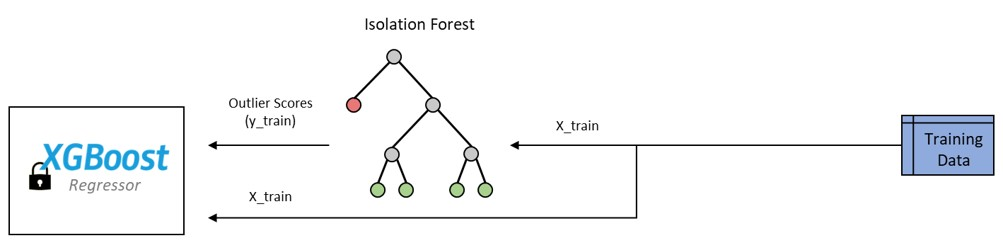

In [13]:
# ################################################################################
# # XGBoost Anomaly Detector
# ################################################################################

# class AnomalyDetector:
#   def __init__(self):
#     self.xgb = None
#     self.iso = None
#     self.log = {
#         'train':       None,
#         'evaluate_total':  None,
#         'evaluate_sample': None
#       }

#   def train(self, X):
#     # training
#     start_time = time.time()
#     self.iso = IsolationForest().fit(X)
#     ytrain_iso = np.where(self.iso.predict(X) == -1, 1, 0)
#     self.xgb = XGBClassifier(random_state=self.random_state).fit(X, ytrain_iso)
#     self.log['train'] = time.time() - start_time
#     return self

#   def evaluate(self, X, model='xgb'):
#     if model=='xgb':
#       # predict
#       start_time = time.time()
#       ypred = self.xgb.predict(X)
#       self.log['evaluate_total'] = time.time() - start_time
#       self.log['evaluate_sample'] = self.log['evaluate_total']/len(X)
#       return ypred
#     elif model=='iso':
#       return np.where(self.iso.predict(X) == -1, 1, 0)

# ################################################################################
# # Concrete Anomaly Detector
# ################################################################################

# class ConcreteAnomalyDetector:
#   def __init__(self, n_bits=2):
#     self.n_bits = n_bits
#     self.xgb = None
#     self.iso = None
#     self.fhe_circuit = None
#     self.log = {
#         'train':       None,
#         'compile':        None,
#         'keygen':         None,
#         'evaluate_total':  None,
#         'evaluate_sample': None
#       }

#   def train(self, X):
#     # training
#     start_time = time.time()
#     self.iso = IsolationForest().fit(X)
#     ytrain_iso = np.where(self.iso.predict(X) == -1, 1, 0)
#     self.xgb = ConcreteXGBClassifier(n_bits=self.n_bits, random_state=self.random_state).fit(X, ytrain_iso)
#     self.log['train'] = time.time() - start_time
#     # compile
#     start_time = time.time()
#     self.fhe_circuit = self.xgb.compile(X[:100])
#     self.log['compile'] = time.time() - start_time
#     return self

#   def evaluate(self, X, fhe='simulate'):
#     # key generation
#     start_time = time.time()
#     self.fhe_circuit.keygen(force=True)
#     self.log['keygen'] = time.time() - start_time
#     # predict
#     start_time = time.time()
#     ypred = [self.xgb.predict(X[[i], :], fhe=fhe)[0] for i in tqdm(range(X.shape[0]))]
#     self.log['evaluate_total'] = time.time() - start_time
#     self.log['evaluate_sample'] = self.log['evaluate_total']/len(X)
#     return ypred

### XGBoost

In [14]:
# ad = AnomalyDetector().train(xtrain)

In [15]:
# # predict and plot Isolation Forest results
# ypred_iso = ad.evaluate(xtest, model='iso')
# plot_classification_metrics(ytest, ypred_iso, plot_title='Isolation Forest Results')

In [16]:
# # predict and plot XGBoost results
# ypred_xgb = ad.evaluate(xtest, model='xgb')
# plot_classification_metrics(ytest, ypred_xgb, plot_title='XGBoost Results')

In [17]:
# ad_results = pd.DataFrame(ad.log, index=[0])
# ad_results

### Concrete

In [18]:
# results = {'n_bits': [], 'y_pred': [], 'times': [], 'metrics': []}

# for n_bits in range(2,7):

#   cad = ConcreteAnomalyDetector(n_bits=n_bits)
#   y_pred = cad.train(xtrain_bert).evaluate(xtest_bert, fhe='simulate')
#   metrics = {
#       'accuracy':   accuracy_score(ytest, y_pred),
#       'precision':  precision_score(ytest, y_pred),
#       'recall':     recall_score(ytest, y_pred),
#       'f1':         f1_score(ytest, y_pred)
#   }

#   results['n_bits'].append(n_bits)
#   results['y_pred'].append(y_pred)
#   results['times'].append(cad.log)
#   results['metrics'].append(metrics)

In [19]:
# for preds, bits in zip(results['y_pred'], results['n_bits']):
#   print(f'########################### bits = {bits} ###########################')
#   plot_classification_metrics(ytest, preds, plot_title=f'Quantization (n_bits={bits})')

In [20]:
# cad_results = pd.concat([pd.DataFrame.from_records(results['times']), pd.DataFrame.from_records(results['metrics'])], axis=1)
# cad_results.insert(0, 'n_bits', results['n_bits'])
# cad_results

## Approach 2: Autoencoder

The idea behind an _Autoencoder_ is to constrain a neural network with a bottleneck, compelling it to compress input data into a reduced representation and then reconstruct the original input. The core objective is to reproduce the input accurately. By comparing the starting input with what the autoencoder rebuilds, we can pinpoint anomalies by noticing where errors in the recreation process are substantially higher.
<br></br>
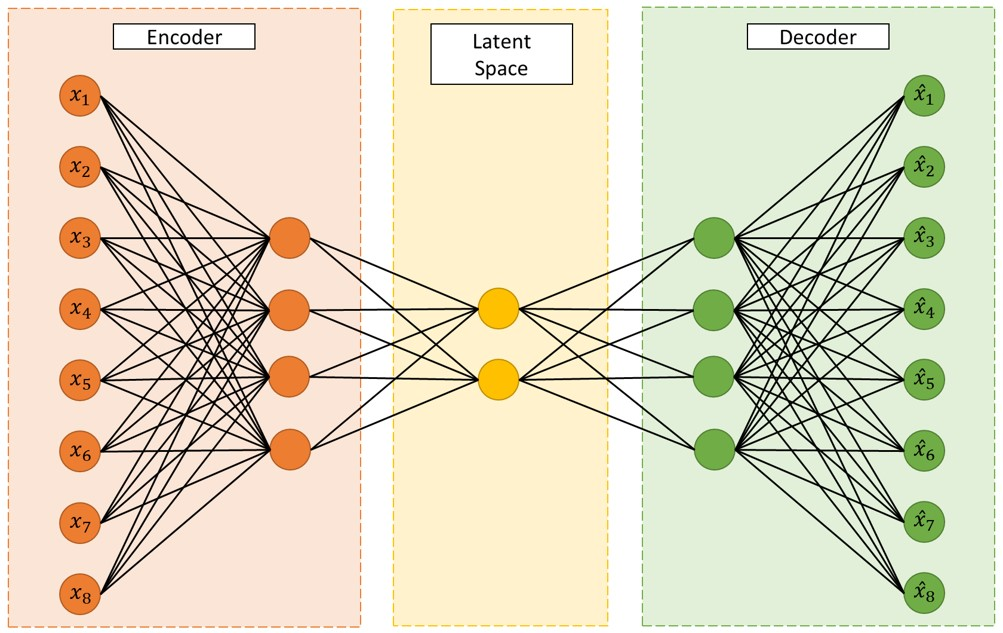

In [21]:
################################################################################
# Scikit-Learn Autoencoder
################################################################################

class SklearnAutoencoder():
    def __init__(self, encoding_factor=0.3, threshold_quantile=0.95, learning_rate=0.001, **kwargs):

        self.encoding_factor = encoding_factor
        self.threshold_quantile = threshold_quantile
        self.model = MLPRegressor(learning_rate_init=learning_rate, **kwargs)
        self.threshold = None
        self.log = {
            'train': None,
            'evaluate_total': None,
            'evaluate_sample': None
        }

    def train(self, X, epochs=20):
        # set hidden layer size
        hidden_layer_size = (int(self.encoding_factor * X.shape[1]),)
        # set parameters
        self.model.hidden_layer_sizes = hidden_layer_size
        self.model.max_iter = epochs
        # train model
        start_time = time.time()
        self.model.fit(X, X)
        self.log['train'] = time.time() - start_time
        # calculate threshold
        reconstruction_error = np.mean((X - self.model.predict(X))**2, axis=1)
        self.threshold = np.percentile(reconstruction_error, self.threshold_quantile*100)

        return self
    
    def evaluate(self, X):
        # evaluate model
        start_time = time.time()
        reconstruction_error = np.mean((X - self.model.predict(X))**2, axis=1)
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # create labels
        ypred = np.where(reconstruction_error > self.threshold, 1, 0)

        return ypred
    

################################################################################
# Concrete Autoencoder
################################################################################

class ConcreteAutoencoder():
    def __init__(self, n_bits=2, encoding_factor=0.3, threshold_quantile=0.95, learning_rate=0.001, **kwargs):

        self.n_bits = n_bits
        self.encoding_factor = encoding_factor
        self.threshold_quantile = threshold_quantile
        self.model = ConcreteMLPRegressor(lr=learning_rate, verbose=0, **kwargs)
        self.threshold = None
        self.log = {
            'train': None,
            'compile': None,
            'keygen': None,
            'evaluate_total': None,
            'evaluate_sample': None
        }

    def train(self, X, epochs=20):
        # set parameters
        self.model.module__n_layers = 1
        self.model.module__n_w_bits = self.n_bits
        self.model.module__n_a_bits = self.n_bits
        self.model.module__n_hidden_neurons_multiplier = self.encoding_factor
        self.model.max_epochs = epochs
        # train model
        start_time = time.time()
        self.model.fit(X, X)
        self.log['train'] = time.time() - start_time
        # calculate threshold
        reconstruction_error = np.mean((X - self.model.predict(X))**2, axis=1)
        self.threshold = np.percentile(reconstruction_error, self.threshold_quantile*100)
        # compile
        start_time = time.time()
        self.model.compile(X[:100])
        self.log['compile'] = time.time() - start_time
        # remove warnings about output shape
        clear_output()

        return self
    
    def evaluate(self, X, fhe='simulate'):
        # key generation
        start_time = time.time()
        self.model.fhe_circuit.keygen(force=True)
        self.log['keygen'] = time.time() - start_time
        # evaluate model
        start_time = time.time()
        reconstruction_error = np.mean((X - self.model.predict(X, fhe=fhe))**2, axis=1)
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # create labels
        ypred = np.where(reconstruction_error > self.threshold, 1, 0)
        # remove warnings about output shape
        clear_output()

        return ypred

### Scikit-Learn

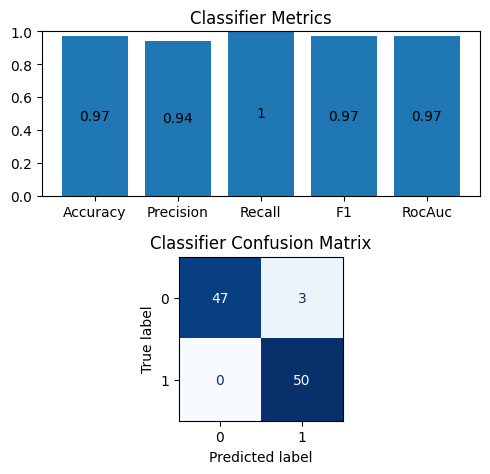

In [22]:
sklearn_autoencoder = SklearnAutoencoder(encoding_factor=0.3, threshold_quantile=0.95)
sklearn_autoencoder = sklearn_autoencoder.train(xtrain)
ypred_sklearn = sklearn_autoencoder.evaluate(xtest)

plot_classification_metrics(ytest, ypred_sklearn)

In [23]:
sklearn_results = pd.DataFrame(sklearn_autoencoder.log, index=[0])
sklearn_results

,train,evaluate_total,evaluate_sample
0,1.594142,0.025236,0.000252


### Concrete

In [24]:
results = {'n_bits': [], 'y_pred': [], 'times': [], 'metrics': []}

for n_bits in range(2,7):
    
    concrete_autoencoder = ConcreteAutoencoder(n_bits=n_bits, encoding_factor=0.3, threshold_quantile=0.95)
    concrete_autoencoder = concrete_autoencoder.train(xtrain)
    ypred_concrete = concrete_autoencoder.evaluate(xtest, fhe='simulate')
    metrics = {
        'accuracy':   accuracy_score(ytest, ypred_concrete),
        'precision':  precision_score(ytest, ypred_concrete),
        'recall':     recall_score(ytest, ypred_concrete),
        'f1':         f1_score(ytest, ypred_concrete)
    }

    results['n_bits'].append(n_bits)
    results['y_pred'].append(ypred_concrete)
    results['times'].append(concrete_autoencoder.log)
    results['metrics'].append(metrics)

########################### bits = 2 ###########################


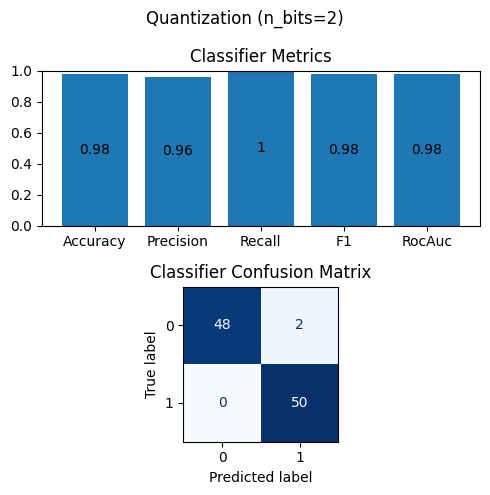

########################### bits = 3 ###########################


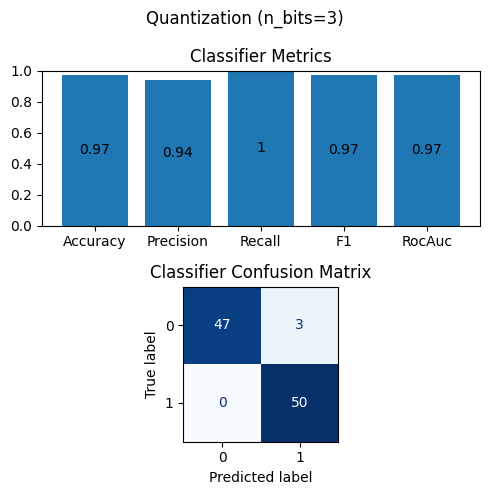

########################### bits = 4 ###########################


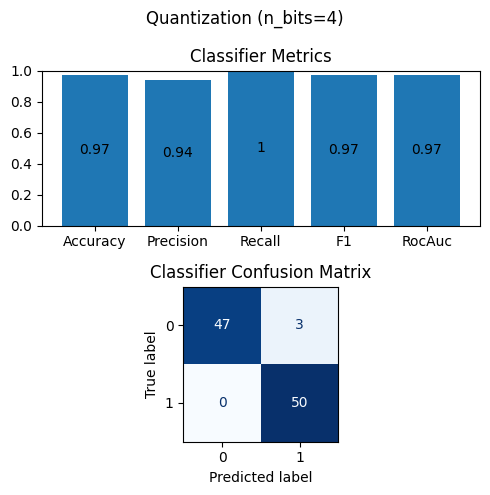

########################### bits = 5 ###########################


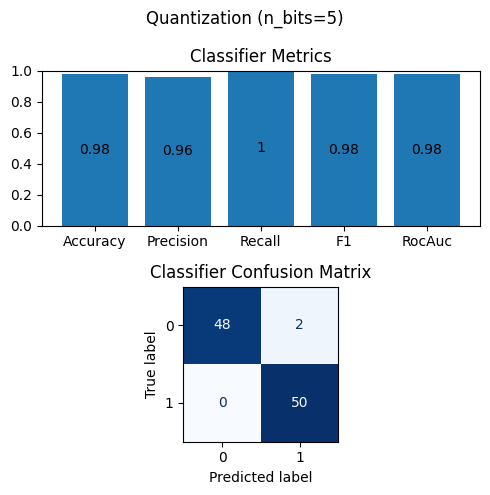

########################### bits = 6 ###########################


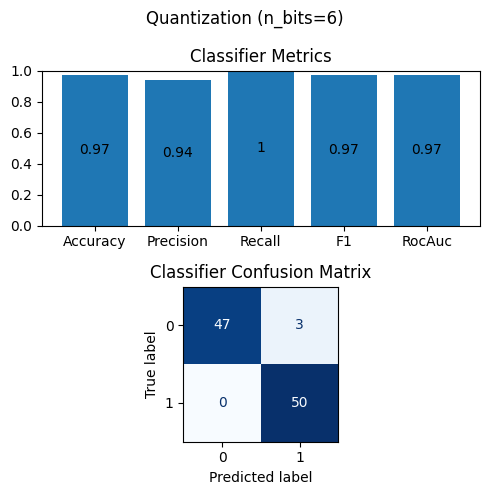

In [25]:
for preds, bits in zip(results['y_pred'], results['n_bits']):
    print(f'########################### bits = {bits} ###########################')
    plot_classification_metrics(ytest, preds, plot_title=f'Quantization (n_bits={bits})')

In [26]:
concrete_results = pd.concat([pd.DataFrame.from_records(results['times']), pd.DataFrame.from_records(results['metrics'])], axis=1)
concrete_results.insert(0, 'n_bits', results['n_bits'])
concrete_results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,2.972302,0.172004,0.000099,0.039160,0.000392,0.98,0.961538,1.0,0.980392
1,3,2.478166,0.156454,0.000089,0.038311,0.000383,0.97,0.943396,1.0,0.970874
2,4,2.721962,0.161460,0.000083,0.037854,0.000379,0.97,0.943396,1.0,0.970874
3,5,2.534046,0.155566,0.000094,0.036240,0.000362,0.98,0.961538,1.0,0.980392
4,6,2.604801,0.154921,0.000087,0.036399,0.000364,0.97,0.943396,1.0,0.970874


# OLD

In [27]:
# ################################################################################
# # PyTorch Autoencoder
# ################################################################################

# class TorchAutoencoder(torch.nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
#         self.criterion = torch.nn.MSELoss()
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
#         self.threshold = None
#         self.log = {
#             'train': None,
#             'evaluate_total': None,
#             'evaluate_sample': None
#         }

#     def train(self, X, epochs=20, verbose=True):
#         X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
#         self.model = self.model.train()
#         # train model
#         start_time = time.time()
#         for epoch in range(epochs):
#             self.optimizer.zero_grad()
#             ypred = self.model(X_tensor)
#             loss = self.criterion(ypred, X_tensor)
#             loss.backward()
#             self.optimizer.step()
#             if (epoch+1)% 5 == 0:
#                 print(f'Epoch: {epoch+1}\tLoss: {loss.item():.4f}') if verbose is True else None
#         self.log['train'] = time.time() - start_time
#         # calculate threshold
#         self.model = self.model.eval()
#         with torch.no_grad():
#             reconstructed_data = self.model(X_tensor)
#         reconstruction_error = torch.mean((X_tensor - reconstructed_data)**2, axis=1)
#         self.threshold = np.percentile(reconstruction_error, 90)
#         return self

#     def evaluate(self, X):
#         X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
#         # evaluate model
#         start_time = time.time()
#         with torch.no_grad():
#             reconstructed_data = self.model(X_tensor)
#         reconstruction_error = torch.mean((X_tensor - reconstructed_data)**2, axis=1)
#         ypred = np.where(reconstruction_error > self.threshold, 1, 0)
#         self.log['evaluate_total'] = time.time() - start_time
#         self.log['evaluate_sample'] = self.log['evaluate_total']/X_tensor.shape[0]
#         return ypred

# ################################################################################
# # Concrete Autoencoder
# ################################################################################

# class ConcreteAutoencoder(torch.nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
#         self.criterion = torch.nn.MSELoss()
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
#         self.threshold = None
#         self.fhe_module = None
#         self.log = {
#             'train': None,
#             'compile': None,
#             'keygen': None,
#             'evaluate_total': None,
#             'evaluate_sample': None
#         }

#     def train(self, X, n_bits, epochs=20, verbose=True):
#         X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
#         self.model = self.model.train()
#         # train model
#         start_time = time.time()
#         for epoch in range(epochs):
#             self.optimizer.zero_grad()
#             ypred = self.model(X_tensor)
#             loss = self.criterion(ypred, X_tensor)
#             loss.backward()
#             self.optimizer.step()
#             if (epoch+1)% 5 == 0:
#                 print(f'Epoch: {epoch+1}\tLoss: {loss.item():.4f}') if verbose is True else None
#         self.log['train'] = time.time() - start_time
#         # calculate threshold
#         self.model = self.model.eval()
#         with torch.no_grad():
#             reconstructed_data = self.model(X_tensor)
#         reconstruction_error = torch.mean((X_tensor - reconstructed_data)**2, axis=1)
#         self.threshold = np.percentile(reconstruction_error, 90)
#         # compile
#         start_time = time.time()
#         self.fhe_module = compile_brevitas_qat_model(self.model, X_tensor[:100], rounding_threshold_bits=n_bits)
#         self.log['compile'] = time.time() - start_time
#     	  # check-up
#         bitwidth = self.fhe_module.fhe_circuit.graph.maximum_integer_bit_width()
#         print('max. bithwidth (16) exceeded!') if bitwidth > 16 else None
#         return self

#     def evaluate(self, X, fhe='simulate'):
#         X_np = np.array(X)
#         # key generation
#         start_time = time.time()
#         self.fhe_module.fhe_circuit.keygen(force=True)
#         self.log['keygen'] = time.time() - start_time
#         # evaluate model
#         start_time = time.time()
#         ypred = [
#             1 if np.mean((self.fhe_module.forward(X_np[[i], :], fhe=fhe) - X_np[[i], :])**2, axis=1) > self.threshold
#             else 0
#             for i in tqdm(range(X_np.shape[0]))
#             ]
#         self.log['evaluate_total'] = time.time() - start_time
#         self.log['evaluate_sample'] = self.log['evaluate_total']/X_np.shape[0]
#         return ypred

### Torch

In [28]:
# input_dim = xtrain.shape[1]
# encoding_dim = input_dim // 10

# print(f'Input Dimension: {input_dim}')
# print(f'Encoding Dimension: {encoding_dim}')

In [29]:
# torch_model = torch.nn.Sequential(
#     torch.nn.Linear(input_dim, encoding_dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(encoding_dim, input_dim),
#     torch.nn.Sigmoid()
# )

In [30]:
# tae = TorchAutoencoder(model=torch_model).train(xtrain)
# ypred_tae = tae.evaluate(xtest)
# plot_classification_metrics(ytest, ypred_tae)

In [31]:
# tae_results = pd.DataFrame(tae.log, index=[0])
# tae_results

### Concrete

In [32]:
# input_dim = xtrain.shape[1]
# encoding_dim = input_dim // 10

# print(f'Input Dimension: {input_dim}')
# print(f'Encoding Dimension: {encoding_dim}')

In [33]:
# results = {'n_bits': [], 'y_pred': [], 'times': [], 'metrics': []}

# for n_bits in range(2,4):

#   brevitas_model = torch.nn.Sequential(
#     brevitas.nn.QuantIdentity(bit_width=n_bits, return_quant_tensor=True),
#     brevitas.nn.QuantLinear(input_dim, encoding_dim, bias=True, weight_bit_width=n_bits),
#     brevitas.nn.QuantReLU(),
#     brevitas.nn.QuantLinear(encoding_dim, input_dim, bias=True, weight_bit_width=n_bits),
#     brevitas.nn.QuantSigmoid()
#   )

#   cae = ConcreteAutoencoder(brevitas_model)
#   y_pred = cae.train(xtrain, n_bits=n_bits, verbose=False).evaluate(xtest, fhe='simulate')
#   metrics = {
#       'accuracy':   accuracy_score(ytest, y_pred),
#       'precision':  precision_score(ytest, y_pred),
#       'recall':     recall_score(ytest, y_pred),
#       'f1':         f1_score(ytest, y_pred)
#   }

#   results['n_bits'].append(n_bits)
#   results['y_pred'].append(y_pred)
#   results['times'].append(cae.log)
#   results['metrics'].append(metrics)

In [34]:
# for preds, bits in zip(results['y_pred'], results['n_bits']):
#   print(f'########################### bits = {bits} ###########################')
#   plot_classification_metrics(ytest, preds, plot_title=f'Quantization (n_bits={bits})')

In [35]:
# cae_results = pd.concat([pd.DataFrame.from_records(results['times']), pd.DataFrame.from_records(results['metrics'])], axis=1)
# cae_results.insert(0, 'n_bits', results['n_bits'])
# cae_results